# ¿Cuál es la mejor tarifa?

 La empresa telecomunicaciones Megaline ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de las tarifas genera más ingresos para poder ajustar el presupuesto de publicidad.

Realizaremos un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendrás los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Analizaremos el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.

## Inicialización

In [1]:
# Cargar todas las librerías
from scipy import stats as st
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## Cargar datos

In [2]:
# Cargar los archivos de datos en diferentes DataFrames

calls = pd.read_csv("/datasets/megaline_calls.csv")
internet = pd.read_csv("/datasets/megaline_internet.csv")
messages = pd.read_csv("/datasets/megaline_messages.csv")
plans = pd.read_csv("/datasets/megaline_plans.csv")
users = pd.read_csv("/datasets/megaline_users.csv")

## Preparar los datos

Usando "info()", se observará el tipo de datos de los dataframes. Los datos tipo object podrían ser transformados en datetime64, luego de identificar los valores ausentes y determinar la razón de los mismos. Esto podría hacerse con "pd.to_datetime()".

La identificacion de los valores ausentes se hará principalmente usando "isna()" y/o "fillna()", dependiendo de las circunstancias.

Los valores duplicados se eliminaran si son filas completas y se analizara con mayor detalle si son en determinadas columnas. Se usaran los métodos "duplicated().sum()" para buscarlos.

## Tarifas

In [3]:
# Imprimir la información general/resumida sobre el DataFrame de las tarifas
plans.info()
# No hay datos nulos, ni duplicados.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [4]:
# Imprimir una muestra de los datos para las tarifas
display(plans)

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


La tabla de de los datos de las tarifas muestran la informacion de la descripción de los planes. Los tipos de datos son adecuados con respecto a la información que describen. No hay datos ausentes. Se obtendran los GB incluidos en los planes y se guardaran en la columna "gb_included".

## Corregir datos

In [5]:
plans["gb_included"] = plans["mb_per_month_included"]/1024
display(plans)

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_included
0,50,15360,500,20,10,0.03,0.03,surf,15.0
1,1000,30720,3000,70,7,0.01,0.01,ultimate,30.0


## Enriquecer los datos

In [6]:
plans = plans.rename(columns={"plan_name": "plan"})
plans = plans.rename(columns={"usd_per_message": "usd_per_messages"})
plans = plans.rename(columns={"usd_per_minute": "usd_per_min"})
plans = plans.rename(columns={"minutes_included": "min_included"})
display(plans)

,messages_included,mb_per_month_included,min_included,usd_monthly_pay,usd_per_gb,usd_per_messages,usd_per_min,plan,gb_included
0,50,15360,500,20,10,0.03,0.03,surf,15.0
1,1000,30720,3000,70,7,0.01,0.01,ultimate,30.0


## Usuarios/as

In [7]:
# Imprimir la información general/resumida sobre el DataFrame de usuarios
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [8]:
# Imprimir una muestra de datos para usuarios
display(users)
display(users.describe())

# Para analizar la proporciones de la población que tienen un determinado plan.
display(users["plan"].value_counts())

# Verificar si hay datos duplicados.
users.duplicated().sum()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN
...,...,...,...,...,...,...,...,...
495,1495,Fidel,Sharpe,67,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-09-04,surf,NaN
496,1496,Ariel,Shepherd,49,"New Orleans-Metairie, LA MSA",2018-02-20,surf,NaN
497,1497,Donte,Barrera,49,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-12-10,ultimate,NaN
498,1498,Scot,Williamson,51,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-02-04,surf,NaN


,user_id,age
count,500.000000,500.000000
mean,1249.500000,45.486000
std,144.481833,16.972269
min,1000.000000,18.000000
25%,1124.750000,30.000000
50%,1249.500000,46.000000
75%,1374.250000,61.000000
max,1499.000000,75.000000


surf        339
ultimate    161
Name: plan, dtype: int64

0

Los nombres estan con mayusculas y minusculas. Normalizaré los nombres volviendo todo a minusculas. 
Los datos de las fechas necesitan ser pasados a Timestamps o datetime. Luego de hacer esto hay que revisar si hay datos duplicados.

Usando el método describe() observamos que todos los usuarios son adultos, entre los 18 a los 75 años. El promedio se encuentra en los 45 años.

Se agregaran columnas para diferenciar los meses cuando se suscribieron los clientes y cuando dejaron de usar el servicio.

No se observan filas duplicadas en el dataframe. 

Hay datosa nulos en la columna de "churn_date". Esto ocurre porque no hay una fecha establecida de cuando los clientes dejaron de usar los planes. Solo tenemos 34 usuarios que dejaron el plan que usaban en una fecha dentro del 2018.

### Corregir los datos

In [9]:
users["first_name"] = users["first_name"].str.lower()
users["last_name"] = users["last_name"].str.lower()
users["city"] = users["city"].str.lower()
users["reg_date"] = pd.to_datetime(users["reg_date"], format="%Y-%m-%d")
users["churn_date"] = pd.to_datetime(users["churn_date"], format="%Y-%m-%d")

display(users)
users.info()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,anamaria,bauer,45,"atlanta-sandy springs-roswell, ga msa",2018-12-24,ultimate,NaT
1,1001,mickey,wilkerson,28,"seattle-tacoma-bellevue, wa msa",2018-08-13,surf,NaT
2,1002,carlee,hoffman,36,"las vegas-henderson-paradise, nv msa",2018-10-21,surf,NaT
3,1003,reynaldo,jenkins,52,"tulsa, ok msa",2018-01-28,surf,NaT
4,1004,leonila,thompson,40,"seattle-tacoma-bellevue, wa msa",2018-05-23,surf,NaT
...,...,...,...,...,...,...,...,...
495,1495,fidel,sharpe,67,"new york-newark-jersey city, ny-nj-pa msa",2018-09-04,surf,NaT
496,1496,ariel,shepherd,49,"new orleans-metairie, la msa",2018-02-20,surf,NaT
497,1497,donte,barrera,49,"los angeles-long beach-anaheim, ca msa",2018-12-10,ultimate,NaT
498,1498,scot,williamson,51,"new york-newark-jersey city, ny-nj-pa msa",2018-02-04,surf,NaT


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


### Enriquecer los datos

In [10]:
users["reg_date_month"] = users["reg_date"].dt.month
users["churn_date_month"] = users["churn_date"].dt.month
display(users)
users.info()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,reg_date_month,churn_date_month
0,1000,anamaria,bauer,45,"atlanta-sandy springs-roswell, ga msa",2018-12-24,ultimate,NaT,12,NaN
1,1001,mickey,wilkerson,28,"seattle-tacoma-bellevue, wa msa",2018-08-13,surf,NaT,8,NaN
2,1002,carlee,hoffman,36,"las vegas-henderson-paradise, nv msa",2018-10-21,surf,NaT,10,NaN
3,1003,reynaldo,jenkins,52,"tulsa, ok msa",2018-01-28,surf,NaT,1,NaN
4,1004,leonila,thompson,40,"seattle-tacoma-bellevue, wa msa",2018-05-23,surf,NaT,5,NaN
...,...,...,...,...,...,...,...,...,...,...
495,1495,fidel,sharpe,67,"new york-newark-jersey city, ny-nj-pa msa",2018-09-04,surf,NaT,9,NaN
496,1496,ariel,shepherd,49,"new orleans-metairie, la msa",2018-02-20,surf,NaT,2,NaN
497,1497,donte,barrera,49,"los angeles-long beach-anaheim, ca msa",2018-12-10,ultimate,NaT,12,NaN
498,1498,scot,williamson,51,"new york-newark-jersey city, ny-nj-pa msa",2018-02-04,surf,NaT,2,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   user_id           500 non-null    int64         
 1   first_name        500 non-null    object        
 2   last_name         500 non-null    object        
 3   age               500 non-null    int64         
 4   city              500 non-null    object        
 5   reg_date          500 non-null    datetime64[ns]
 6   plan              500 non-null    object        
 7   churn_date        34 non-null     datetime64[ns]
 8   reg_date_month    500 non-null    int64         
 9   churn_date_month  34 non-null     float64       
dtypes: datetime64[ns](2), float64(1), int64(3), object(4)
memory usage: 39.2+ KB


## Llamadas

In [11]:
# Imprimir la información general/resumida sobre el DataFrame de las llamadas
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [12]:
# Imprimir una muestra de datos para las llamadas
display(calls)
display(calls.describe())
calls.duplicated().sum()

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22
...,...,...,...,...
137730,1499_199,1499,2018-11-21,8.72
137731,1499_200,1499,2018-10-20,10.89
137732,1499_201,1499,2018-09-21,8.12
137733,1499_202,1499,2018-10-10,0.37


,user_id,duration
count,137735.000000,137735.000000
mean,1247.658046,6.745927
std,139.416268,5.839241
min,1000.000000,0.000000
25%,1128.000000,1.290000
50%,1247.000000,5.980000
75%,1365.000000,10.690000
max,1499.000000,37.600000


0

No hay datos nulos. Las fechas necesitan ser cambiadas a datetime64. 
Cambiaré el nombre de la columna de duracion de llamadas para dejar en claro que son en minutos.
Se agregó una columna para analizar la actividad de llamadas respecto al mes. No hay datos duplicados.
Como los minutos son cobrados desde el momento en que se pasan de un segundo, se hará una columna con los minutos redondeados hacia el entero mayor más cercano.

Tenemos alrededor de 137735 llamadas. De estaas, el promedio es de casi 7 minutos. Encontramos llamadas con cero segundos (probablemente llamadas que no fueron contestadas) y como máximo una llamada de aproximadamente 37 minutos. De acuerdo a los cuartiles, podemos observar que la gran mayoría de las llamadas se encuentran debajo de los 10 minutos.

### Corregir los datos

In [13]:
calls["call_date"] = pd.to_datetime(calls["call_date"], format="%Y-%m-%d")
calls = calls.rename(columns={"duration": "duration_min"})
calls.info()
display(calls)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            137735 non-null  object        
 1   user_id       137735 non-null  int64         
 2   call_date     137735 non-null  datetime64[ns]
 3   duration_min  137735 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.2+ MB


,id,user_id,call_date,duration_min
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22
...,...,...,...,...
137730,1499_199,1499,2018-11-21,8.72
137731,1499_200,1499,2018-10-20,10.89
137732,1499_201,1499,2018-09-21,8.12
137733,1499_202,1499,2018-10-10,0.37


### Enriquecer los datos

In [14]:
calls["call_date_month"] = calls["call_date"].dt.month
calls["duration_min_int"] = np.ceil(calls["duration_min"])
calls.info()
display(calls)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   id                137735 non-null  object        
 1   user_id           137735 non-null  int64         
 2   call_date         137735 non-null  datetime64[ns]
 3   duration_min      137735 non-null  float64       
 4   call_date_month   137735 non-null  int64         
 5   duration_min_int  137735 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(1)
memory usage: 6.3+ MB


,id,user_id,call_date,duration_min,call_date_month,duration_min_int
0,1000_93,1000,2018-12-27,8.52,12,9.0
1,1000_145,1000,2018-12-27,13.66,12,14.0
2,1000_247,1000,2018-12-27,14.48,12,15.0
3,1000_309,1000,2018-12-28,5.76,12,6.0
4,1000_380,1000,2018-12-30,4.22,12,5.0
...,...,...,...,...,...,...
137730,1499_199,1499,2018-11-21,8.72,11,9.0
137731,1499_200,1499,2018-10-20,10.89,10,11.0
137732,1499_201,1499,2018-09-21,8.12,9,9.0
137733,1499_202,1499,2018-10-10,0.37,10,1.0


Se hizo el cambio de tipo de tipo de datos (datetime64) para las fechas. Hicimos esto para poder trabajar eficientemente con estos datos, en dado caso que sea necesario obtener un aspecto del mismo, como el mes cuando se realizó la llamada.

Se hizo una una columna separada con únicamente el mes llamada "call_date_month". Está nos servirá en los análisis siguientes donde queremos ver el comportamiento de los clientes en los diferentes planes a lo largo del año.

Se hizo una columna con los minutos redondeados llamada "duration_min_int". De acuerdo a las especificaciones de las tarifas, si el cliente se pasa por un segundo de un minuto dado, se le cobrara como si hubiera consumido el minuto entero. De esta forma averiguaremos los ingresos por las llamadas. 

## Mensajes

In [15]:
# Imprimir la información general/resumida sobre el DataFrame de los mensajes
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [16]:
# Imprimir una muestra de datos para los mensajes
display(messages)

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26
...,...,...,...
76046,1497_526,1497,2018-12-24
76047,1497_536,1497,2018-12-24
76048,1497_547,1497,2018-12-31
76049,1497_558,1497,2018-12-24


No hay datos nulos, las fechas son datos tipo objetos. Hay que cambiar esto con el método "pd.to_datetime". 
También se agregará una columna para determinar el mes en el que se enviaron los mensajes. Se verificará si existen datos duplicados.

### Corregir los datos

In [17]:
messages["message_date"] = pd.to_datetime(
    messages["message_date"], format="%Y-%m-%d")
messages.info()
display(messages)
messages.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB


,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26
...,...,...,...
76046,1497_526,1497,2018-12-24
76047,1497_536,1497,2018-12-24
76048,1497_547,1497,2018-12-31
76049,1497_558,1497,2018-12-24


0

### Enriquecer los datos

In [18]:
messages["message_date_month"] = messages["message_date"].dt.month
messages.info()
display(messages)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  76051 non-null  object        
 1   user_id             76051 non-null  int64         
 2   message_date        76051 non-null  datetime64[ns]
 3   message_date_month  76051 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 2.3+ MB


,id,user_id,message_date,message_date_month
0,1000_125,1000,2018-12-27,12
1,1000_160,1000,2018-12-31,12
2,1000_223,1000,2018-12-31,12
3,1000_251,1000,2018-12-27,12
4,1000_255,1000,2018-12-26,12
...,...,...,...,...
76046,1497_526,1497,2018-12-24,12
76047,1497_536,1497,2018-12-24,12
76048,1497_547,1497,2018-12-31,12
76049,1497_558,1497,2018-12-24,12


Se hizo el cambio de tipo de tipo de datos (datetime64) para las fechas. Hicimos esto para poder trabajar eficientemente con estos datos, en dado caso que sea necesario obtener un aspecto del mismo, como el mes cuando se realizaron los mensajes.

Se hizo una una columna separada con únicamente el mes llamada "message_date_month". Está nos servirá en los análisis siguientes donde queremos ver el comportamiento de los clientes en los diferentes planes a lo largo del año.

No se observaron datos duplicados.

## Internet

In [19]:
# Imprimir la información general/resumida sobre el DataFrame de internet
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [20]:
# Imprimir una muestra de datos para el tráfico de internet
display(internet)
display(internet.describe())

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22
...,...,...,...,...
104820,1499_215,1499,2018-10-20,218.06
104821,1499_216,1499,2018-12-30,304.72
104822,1499_217,1499,2018-09-22,292.75
104823,1499_218,1499,2018-12-07,0.00


,user_id,mb_used
count,104825.000000,104825.000000
mean,1242.496361,366.713701
std,142.053913,277.170542
min,1000.000000,0.000000
25%,1122.000000,136.080000
50%,1236.000000,343.980000
75%,1367.000000,554.610000
max,1499.000000,1693.470000


No hay datos nulos, las fechas son datos tipo objetos. Hay que cambiar esto con el método "pd.to_datetime". 
También se agregará una columna para clarificar cuantos GB se usaron al mes. Se verificará si existen datos duplicados.

El promedio es de aproximadamente 0.367 GB y tenemos usuarios que no usaron ningún GB (mostrado por el mínimo de cero). De acuerdo a los cuartiles, podemos observar que la gran mayoría de los datos usados se encuentran debajo de los 0.54 GB.

Se cambiaran de MB a GB, para trabajar los datos del cliente.

### Corregir los datos

In [21]:
internet["session_date"] = pd.to_datetime(
    internet["session_date"], format="%Y-%m-%d")
internet.info()
display(internet)
internet.duplicated().sum()  # No hay datos duplicados.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.2+ MB


,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22
...,...,...,...,...
104820,1499_215,1499,2018-10-20,218.06
104821,1499_216,1499,2018-12-30,304.72
104822,1499_217,1499,2018-09-22,292.75
104823,1499_218,1499,2018-12-07,0.00


0

### Enriquecer los datos

In [22]:
internet["session_date_month"] = internet["session_date"].dt.month
internet.info()
display(internet)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   id                  104825 non-null  object        
 1   user_id             104825 non-null  int64         
 2   session_date        104825 non-null  datetime64[ns]
 3   mb_used             104825 non-null  float64       
 4   session_date_month  104825 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 4.0+ MB


,id,user_id,session_date,mb_used,session_date_month
0,1000_13,1000,2018-12-29,89.86,12
1,1000_204,1000,2018-12-31,0.00,12
2,1000_379,1000,2018-12-28,660.40,12
3,1000_413,1000,2018-12-26,270.99,12
4,1000_442,1000,2018-12-27,880.22,12
...,...,...,...,...,...
104820,1499_215,1499,2018-10-20,218.06,10
104821,1499_216,1499,2018-12-30,304.72,12
104822,1499_217,1499,2018-09-22,292.75,9
104823,1499_218,1499,2018-12-07,0.00,12


Se hizo el cambio de tipo de tipo de datos (datetime64) para las fechas. Hicimos esto para poder trabajar eficientemente con estos datos, en dado caso que sea necesario obtener un aspecto del mismo, como el mes cuando se realizaron los mensajes.

Se hizo una una columna separada con únicamente el mes llamada "session_date_month". Está nos servirá en los análisis siguientes donde queremos ver el comportamiento de los clientes en los diferentes planes a lo largo del año.

No se observaron datos duplicados.

## Estudiar las condiciones de las tarifas

In [23]:
# Imprimir las condiciones de la tarifa y asegúrate de que te quedan claras
display(plans)

,messages_included,mb_per_month_included,min_included,usd_monthly_pay,usd_per_gb,usd_per_messages,usd_per_min,plan,gb_included
0,50,15360,500,20,10,0.03,0.03,surf,15.0
1,1000,30720,3000,70,7,0.01,0.01,ultimate,30.0


## Agregar datos por usuario

In [24]:
# Calcular el número de llamadas hechas por cada usuario al mes. Guarda el resultado.
calls_per_user_per_month = calls.groupby(["user_id", "call_date_month"])[
    "id"].count().sort_index().reset_index()
calls_per_user_per_month.columns = ['user_id', 'month', "calls"]
calls_per_user_per_month

,user_id,month,calls
0,1000,12,16
1,1001,8,27
2,1001,9,49
3,1001,10,65
4,1001,11,64
...,...,...,...
2253,1498,12,39
2254,1499,9,41
2255,1499,10,53
2256,1499,11,45


In [25]:
# Calcular la cantidad de minutos usados por cada usuario al mes. Guarda el resultado.
min_per_user_per_month = calls.groupby(["user_id", "call_date_month"])[
    "duration_min_int"].sum().sort_index().reset_index()
min_per_user_per_month.columns = ['user_id', 'month', "min"]
min_per_user_per_month

,user_id,month,min
0,1000,12,124.0
1,1001,8,182.0
2,1001,9,315.0
3,1001,10,393.0
4,1001,11,426.0
...,...,...,...
2253,1498,12,339.0
2254,1499,9,346.0
2255,1499,10,385.0
2256,1499,11,308.0


In [26]:
# Calcular el número de mensajes enviados por cada usuario al mes. Guarda el resultado.
messages_per_user_per_month = messages.groupby(["user_id", "message_date_month"])[
    "id"].count().sort_index().reset_index()
messages_per_user_per_month.columns = ['user_id', 'month', "messages"]
messages_per_user_per_month

,user_id,month,messages
0,1000,12,11
1,1001,8,30
2,1001,9,44
3,1001,10,53
4,1001,11,36
...,...,...,...
1801,1496,9,21
1802,1496,10,18
1803,1496,11,13
1804,1496,12,11


In [27]:
# Calcular el volumen del tráfico de Internet usado por cada usuario al mes. Guarda el resultado.
internet_per_user_per_month = internet.groupby(["user_id", "session_date_month"])[
    "mb_used"].sum().sort_index().reset_index()
internet_per_user_per_month.columns = ['user_id', 'month', "mb"]
internet_per_user_per_month["gb_not_rounded"] = internet_per_user_per_month["mb"]/1024
internet_per_user_per_month["gb"] = np.ceil(
    internet_per_user_per_month["gb_not_rounded"])
display(internet_per_user_per_month)

,user_id,month,mb,gb_not_rounded,gb
0,1000,12,1901.47,1.856904,2.0
1,1001,8,6919.15,6.756982,7.0
2,1001,9,13314.82,13.002754,14.0
3,1001,10,22330.49,21.807119,22.0
4,1001,11,18504.30,18.070605,19.0
...,...,...,...,...,...
2272,1498,12,23137.69,22.595400,23.0
2273,1499,9,12984.76,12.680430,13.0
2274,1499,10,19492.43,19.035576,20.0
2275,1499,11,16813.83,16.419756,17.0


In [28]:
# Fusionar los datos de llamadas, minutos, mensajes e Internet con base en user_id y month
merge_per_month = internet_per_user_per_month.merge(
    messages_per_user_per_month, on=["month", "user_id"], how='outer')
merge_per_month = merge_per_month.merge(
    min_per_user_per_month, on=["month", "user_id"], how='outer')
merge_per_month = merge_per_month.merge(calls_per_user_per_month, on=[
                                        "month", "user_id"], how='outer')
merge_per_month.fillna(0, inplace=True)
display(merge_per_month)
merge_per_month.info()

,user_id,month,mb,gb_not_rounded,gb,messages,min,calls
0,1000,12,1901.47,1.856904,2.0,11.0,124.0,16.0
1,1001,8,6919.15,6.756982,7.0,30.0,182.0,27.0
2,1001,9,13314.82,13.002754,14.0,44.0,315.0,49.0
3,1001,10,22330.49,21.807119,22.0,53.0,393.0,65.0
4,1001,11,18504.30,18.070605,19.0,36.0,426.0,64.0
...,...,...,...,...,...,...,...,...
2288,1470,12,0.00,0.000000,0.0,153.0,592.0,78.0
2289,1482,10,0.00,0.000000,0.0,2.0,0.0,0.0
2290,1484,11,0.00,0.000000,0.0,1.0,38.0,2.0
2291,1491,4,0.00,0.000000,0.0,6.0,44.0,8.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 0 to 2292
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_id         2293 non-null   int64  
 1   month           2293 non-null   int64  
 2   mb              2293 non-null   float64
 3   gb_not_rounded  2293 non-null   float64
 4   gb              2293 non-null   float64
 5   messages        2293 non-null   float64
 6   min             2293 non-null   float64
 7   calls           2293 non-null   float64
dtypes: float64(6), int64(2)
memory usage: 161.2 KB


In [29]:
# Añadir la información de la tarifa
merge_per_month_plan = merge_per_month.merge(
    users[["plan", "user_id"]], on="user_id", how='outer')
merge_per_month_plan.info()
# Se eliminaran los datos ausentes, ya que tenemos ID's de usuarios que no tienen:
# mes, gb, mensajes, minutos o llamadas asignadas. Desaparecimos diez datos.
merge_per_month_plan.dropna(inplace=True)
display(merge_per_month_plan)
merge_per_month_plan["gb"] = merge_per_month_plan["gb"].astype("int")
merge_per_month_plan["messages"] = merge_per_month_plan["messages"].astype(
    "int")
merge_per_month_plan["min"] = merge_per_month_plan["min"].astype("int")
merge_per_month_plan["calls"] = merge_per_month_plan["calls"].astype("int")
merge_per_month_plan["month"] = merge_per_month_plan["month"].astype("int")
merge_per_month_plan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2303 entries, 0 to 2302
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_id         2303 non-null   int64  
 1   month           2293 non-null   float64
 2   mb              2293 non-null   float64
 3   gb_not_rounded  2293 non-null   float64
 4   gb              2293 non-null   float64
 5   messages        2293 non-null   float64
 6   min             2293 non-null   float64
 7   calls           2293 non-null   float64
 8   plan            2303 non-null   object 
dtypes: float64(7), int64(1), object(1)
memory usage: 179.9+ KB


,user_id,month,mb,gb_not_rounded,gb,messages,min,calls,plan
0,1000,12.0,1901.47,1.856904,2.0,11.0,124.0,16.0,ultimate
1,1001,8.0,6919.15,6.756982,7.0,30.0,182.0,27.0,surf
2,1001,9.0,13314.82,13.002754,14.0,44.0,315.0,49.0,surf
3,1001,10.0,22330.49,21.807119,22.0,53.0,393.0,65.0,surf
4,1001,11.0,18504.30,18.070605,19.0,36.0,426.0,64.0,surf
...,...,...,...,...,...,...,...,...,...
2288,1470,8.0,0.00,0.000000,0.0,141.0,580.0,84.0,surf
2289,1470,9.0,0.00,0.000000,0.0,130.0,471.0,70.0,surf
2290,1470,10.0,0.00,0.000000,0.0,145.0,459.0,72.0,surf
2291,1470,11.0,0.00,0.000000,0.0,156.0,632.0,81.0,surf


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 0 to 2292
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_id         2293 non-null   int64  
 1   month           2293 non-null   int64  
 2   mb              2293 non-null   float64
 3   gb_not_rounded  2293 non-null   float64
 4   gb              2293 non-null   int64  
 5   messages        2293 non-null   int64  
 6   min             2293 non-null   int64  
 7   calls           2293 non-null   int64  
 8   plan            2293 non-null   object 
dtypes: float64(2), int64(6), object(1)
memory usage: 179.1+ KB


In [30]:
# Calcular el ingreso mensual para cada usuario
# Se usa el merge_per_month_plan
def plan_income(plan, row):
    """
    Calcular los ingresos de un plan.
    Argumentos:
        plan: Tipo de plan
        row: Una fila de un pandas DataFrame con los detalles del plan y/o el uso por usuario.
    Returns:
        Ingreso generado por el plan
    """
    resources = ["messages", "gb", "min"]
    income = 0

    for resource in resources:
        included = plans.loc[plans["plan"] ==
                             plan, f"{resource}_included"].iloc[0]
        used = row[resource]
        cost_per_unit = plans.loc[plans["plan"] ==
                                  plan, f"usd_per_{resource}"].iloc[0]

        if used > included:
            income += (used - included) * cost_per_unit

    if plan in ["ultimate", "surf"]:
        income += plans.loc[plans["plan"] == plan, "usd_monthly_pay"].iloc[0]

    return income


def calculate_user_income(df):
    user_incomes = []

    for _, row in df.iterrows():
        plan = row["plan"]
        user_income = plan_income(plan, row)
        user_incomes.append(user_income)

    df["user_income"] = user_incomes
    return df


merge_per_month_plan = calculate_user_income(merge_per_month_plan)

display(merge_per_month_plan)

,user_id,month,mb,gb_not_rounded,gb,messages,min,calls,plan,user_income
0,1000,12,1901.47,1.856904,2,11,124,16,ultimate,70.00
1,1001,8,6919.15,6.756982,7,30,182,27,surf,20.00
2,1001,9,13314.82,13.002754,14,44,315,49,surf,20.00
3,1001,10,22330.49,21.807119,22,53,393,65,surf,90.09
4,1001,11,18504.30,18.070605,19,36,426,64,surf,60.00
...,...,...,...,...,...,...,...,...,...,...
2288,1470,8,0.00,0.000000,0,141,580,84,surf,25.13
2289,1470,9,0.00,0.000000,0,130,471,70,surf,22.40
2290,1470,10,0.00,0.000000,0,145,459,72,surf,22.85
2291,1470,11,0.00,0.000000,0,156,632,81,surf,27.14


Primero se calculó el número de llamadas hechas por cada usario al mes. Se utilizo el dataframe de "calls" para esto, agrupando el id de las llamadas por el id del usuario y el mes de cada llamada. Esto fue guardado en el dataframe "calls_per_user_per_month".

Se repitió la dinámica con la cantidad de minutos (en llamada), los GB y mensajes usados. Asi obtuvimos otros tres dataframes: "min_per_user_per_month", "messages_per_user_per_month" e "internet_per_user_per_month".

Se fusionaron estos 4 dataframes usando como base el mes y el id del usuario. Se eliminaron los datos ausentes o se llenaron con 0 dependiendo de la situación. En el caso de los eliminados, teníamos ID's de usuarios sin mes, GB, mensajes, minutos o llamadas asignadas. Desaparecimos diez datos. Se formó el datafarme "merge_per_month_plan".

Luego de tener los datos relativamente limpios, se transformaron todos los tipos de datos a excepción de aquellos de la columna "plan", en enteros. Esto se realizó para facilitar cualquier ejercicio que hagamos sobre estos últimos.

Se crearon dos funciones:

La primera ("plan_income()") calcula los ingresos basandose en un plan, teniendo como argumentos el tipo de plan y la fila del dataframe con los detalles del plan y/o uso por usuario. Nos regresa el ingreso generado por el plan.

La segunda función ("calculate_user_income") nos ayuda a obtener el ingreso de cada usuario por caada fila en un dataframe. Tenemos como argumento el dataframe con los datos de los ingresos. Se usa "plan_income()" que es iterado en cada fila de un dataframe determinado. Devuelve el dataframe original adicionando una columna llamada "user_income".

Luego de usar la función calculate_user_income() sobre "merge_per_month_plan", obtuvimos la columna de "user_income" con los ingresos de cada usuario, de acuerdo a lo que consumió y el plan usado.

## Estudia el comportamiento de usuario

### Llamadas

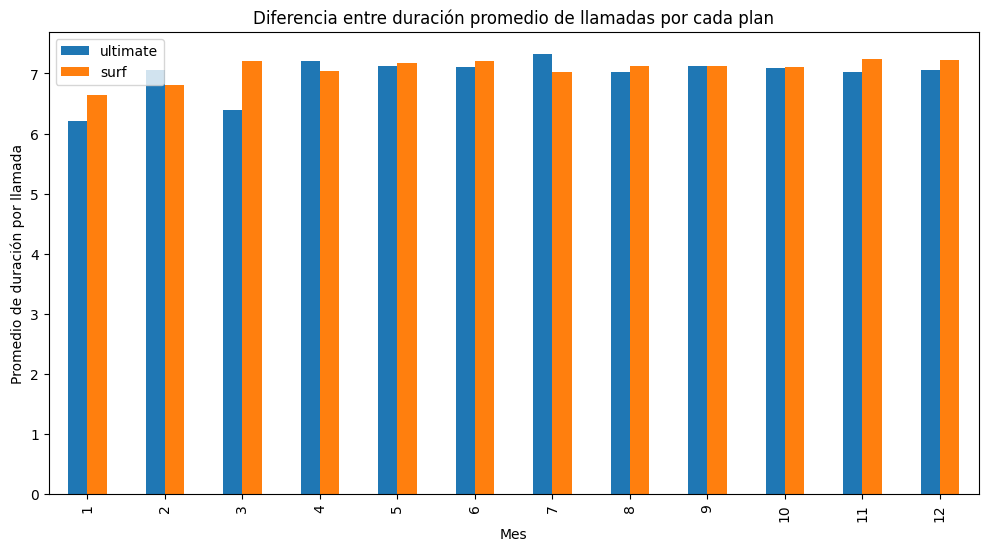

In [31]:
# Comparar la duración promedio de llamadas por cada plan y por cada mes. Traza un gráfico de barras para visualizarla.

# Primero usando el dataframe de merge_per_month_plan separamos los datos en dos dataframes de acuerdo al plan,
# con las columnas que nos interesan.
mean_calls_ultimate = merge_per_month_plan[(
    merge_per_month_plan["plan"] == "ultimate")][["month", "calls", "min"]]
mean_calls_surf = merge_per_month_plan[(merge_per_month_plan["plan"] == "surf")][[
    "month", "calls", "min"]]

# Segundo, hacemos un promedio de la duracion promedio por llamada de usuarios.
mean_calls_ultimate["min_per_call"] = mean_calls_ultimate["min"] / \
    mean_calls_ultimate["calls"]
mean_calls_surf["min_per_call"] = mean_calls_surf["min"] / \
    mean_calls_surf["calls"]

# Tercero, eliminamos los datos ausentes.
mean_calls_ultimate = mean_calls_ultimate.dropna()
mean_calls_surf = mean_calls_surf.dropna()

# Cuarto, agrupamos los datos para obtener los promedios de minutos por llamada por cada mes.
mean_calls_ultimate = mean_calls_ultimate.groupby(["month"])[
    "min_per_call"].mean()
mean_calls_surf = mean_calls_surf.groupby(["month"])["min_per_call"].mean()

# Quinto, concatenamos.
mean_calls_concat = pd.concat([mean_calls_ultimate, mean_calls_surf], axis=1)
mean_calls_concat.columns = ["ultimate", "surf"]

# Sexto, mostramos la gráfica.
mean_calls_concat.plot(kind='bar',
                       title='Diferencia entre duración promedio de llamadas por cada plan',
                       xlabel='Mes',
                       ylabel='Promedio de duración por llamada',
                       figsize=[12, 6])
plt.legend(['ultimate', 'surf'])
plt.show()

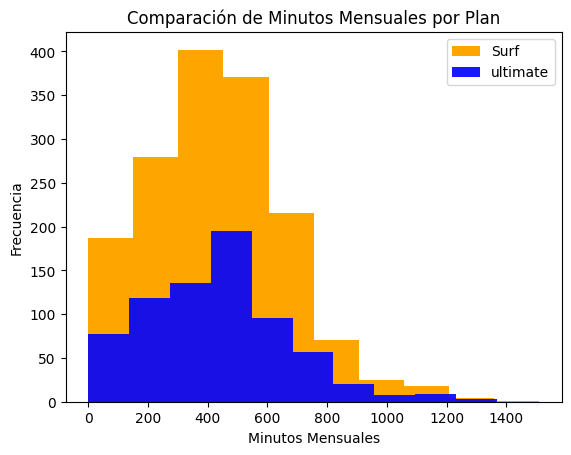

In [32]:
# Comparar el número de minutos mensuales que necesitan los usuarios de cada plan. Traza un histograma.

# Primero usando el dataframe de merge_per_month_plan separamos los datos en un nuevo dataframe de acuerdo al plan,
# con las columnas que nos interesan.
user_min_month = merge_per_month_plan[["month", "min", "plan"]]

# Segundo, mostrar el gráfico del plan surf
user_min_month[user_min_month["plan"] == "surf"]["min"].plot(
    kind='hist', color="orange")

# Tercero,  mostrar el gráfico del plan ultimate
user_min_month[user_min_month["plan"] == "ultimate"]["min"].plot(
    kind='hist', alpha=0.9, color="blue")

plt.legend(['Surf', 'ultimate'])
plt.title('Comparación de Minutos Mensuales por Plan')
plt.xlabel('Minutos Mensuales')
plt.ylabel('Frecuencia')
plt.show()

,month,plan,mean,var,std,median
0,1,surf,203.000000,15842.000000,125.865007,203.0
1,1,ultimate,193.500000,16572.333333,128.733575,234.0
2,2,surf,297.000000,52226.500000,228.531179,254.0
3,2,ultimate,403.142857,76889.476190,277.289517,428.0
4,3,surf,330.000000,35809.363636,189.233622,334.0
5,3,ultimate,304.250000,61984.931818,248.967732,251.0
6,4,surf,351.540000,50866.743265,225.536567,339.5
7,4,ultimate,336.857143,34888.928571,186.785783,301.0
8,5,surf,399.584416,59754.219754,244.446763,415.0
9,5,ultimate,406.241379,43841.046798,209.382537,407.0


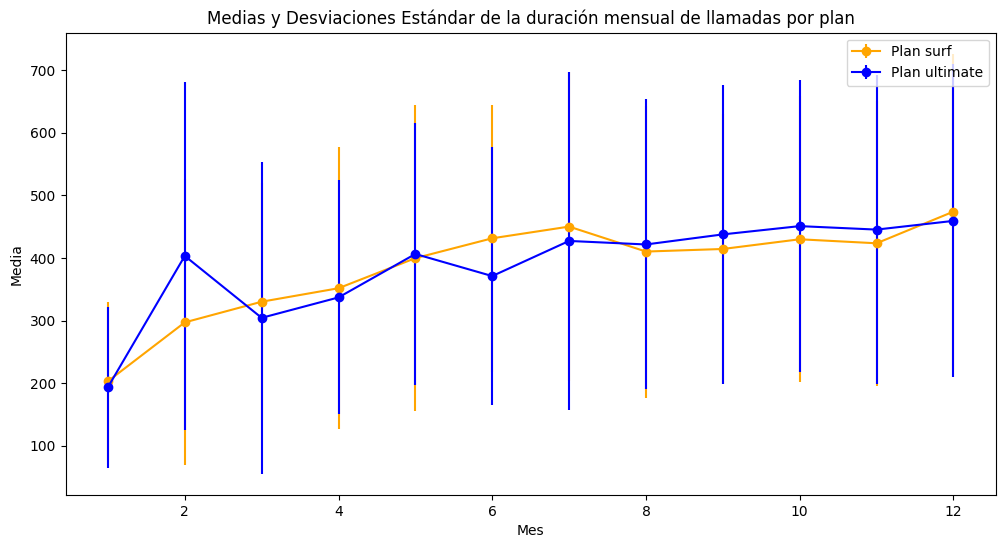

In [33]:
# Calcular la media y la varianza de la duración mensual de llamadas.
# Calcular la media y varianza solo para la columna "min"
merge_mean_var_stats_min = user_min_month.groupby(
    ["month", "plan"])["min"].agg(['mean', "var", "std", "median"]).reset_index()
display(merge_mean_var_stats_min)

# Crear la gráfica de barras con bandas de error (aunque por alguna razón no se ven)
plt.figure(figsize=(12, 6))

for plan, color in zip(merge_mean_var_stats_min['plan'].unique(), ['orange', 'blue']):
    subset = merge_mean_var_stats_min[merge_mean_var_stats_min['plan'] == plan]
    plt.errorbar(subset['month'], subset['mean'], yerr=subset['std'],
                 fmt='-o', label=f'Plan {plan}', color=color)

plt.title(
    'Medias y Desviaciones Estándar de la duración mensual de llamadas por plan')
plt.xlabel('Mes')
plt.ylabel('Media')
plt.legend()
plt.show()

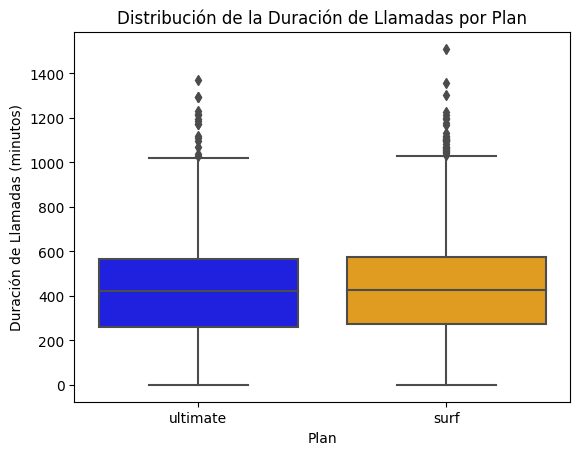

In [34]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas
sns.boxplot(x="plan", y="min", data=user_min_month,
            palette=['blue', 'orange'])
plt.title('Distribución de la Duración de Llamadas por Plan')
plt.xlabel('Plan')
plt.ylabel('Duración de Llamadas (minutos)')
plt.show()

No se observan grandes diferencias en el comportamiento de los usuarios con respecto a las llamadas. En ambos casos, la mayoría de los valores se encuentran alrededor de 500 minutos, como los que están de manera estándar en el plan "surf".  

En la primera gráfica vemos la comparación del promedio de la duración de las llamadas a lo largo del año, de acuerdo al plan de los usuarios. Observamos un comportamiento similar en ambos planes, teniendo la  mayor diferencia en el mes de Marzo con un promedio mayor por parte de los usuarios del plan surf. 

En el histograma observamos que hay una mayor proporción de usuarios haciendo llamadas en el plan surf a comparación del plan ultimate, aunque ambos poseen estructuras similares. Hay un promedio alrededor de 400-600 mensajes por mes. Los datos están sesgados a la derecha. Esto concuerda con los datos del plan, donde el plan "surf" tiene como base 500 minutos al mes.

Luego analizamos el promedio y la varianza de la duración de mensual de las llamadas. Graficamos el promedio y la desviación estandar (la raíz cuadrada de la varianza) y observamos que las desviaciones se sobrelapan entre si. Este es un indicio de que no hay diferencias significativas entre los comportamientos entre ambos planes.

En la gráfica de caja y bigotes observamos que las cajas son relativamente cortas y los bigotes son largos, indicando una distribución donde la mayoría de los datos se concentran alrededor de los 400 minutos, donde encontramos la mediana. Se observan algunos valores extremos. En el plan surf se observá un mayor sesgo debido a estos últimos.  

### Mensajes

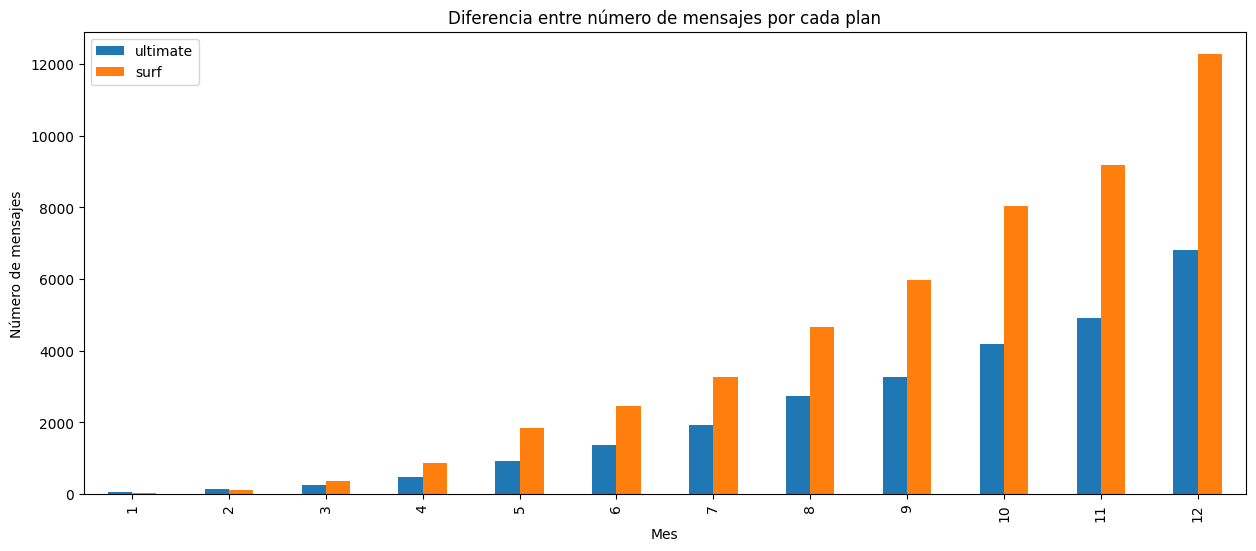

In [35]:
# Comparar el número de mensajes que tienden a enviar cada mes los usuarios de cada plan

# Primero usando el dataframe de merge_per_month_plan separamos los datos en dos dataframes de acuerdo al plan,
# con las columnas que nos interesan.
messages_ultimate = merge_per_month_plan[(
    merge_per_month_plan["plan"] == "ultimate")][["month", "messages"]]
messages_surf = merge_per_month_plan[(merge_per_month_plan["plan"] == "surf")][[
    "month", "messages"]]

# Tercero, agrupamos los datos para obtener los  de mensajes por mes.
messages_ultimate = messages_ultimate.groupby("month")["messages"].sum()
messages_surf = messages_surf.groupby("month")["messages"].sum()

# Cuarto, concatenamos.
mean_messages_concat = pd.concat([messages_ultimate, messages_surf], axis=1)
mean_messages_concat.columns = ["ultimate", "surf"]

# Quinto, mostramos la gráfica.
mean_messages_concat.plot(kind='bar',
                          title='Diferencia entre número de mensajes por cada plan',
                          xlabel='Mes',
                          ylabel='Número de mensajes',
                          figsize=[15, 6])
plt.legend(['ultimate', 'surf'])
plt.show()

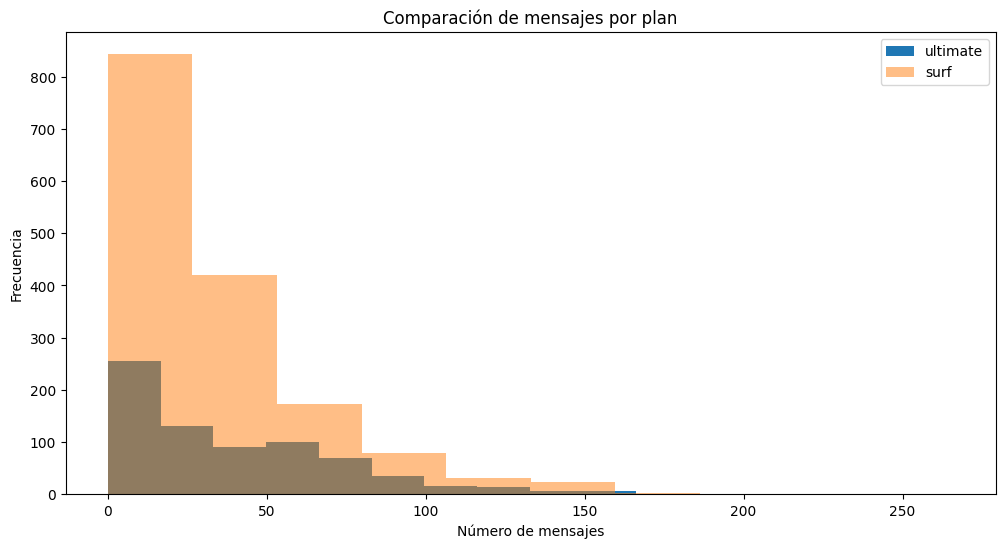

In [36]:
# Comparar la cantidad de mensajes mensuales por plan
# Primero usando el dataframe de merge_per_month_plan separamos los datos en un nuevo dataframe de acuerdo al plan,
# con las columnas que nos interesan.
user_messages_month = merge_per_month_plan[["month", "messages", "plan"]]

# Segundo, mostrar el gráfico del plan ultimate y surf
user_messages_month[user_messages_month["plan"] ==
                    "ultimate"]["messages"].plot(kind='hist', figsize=(12, 6))
user_messages_month[user_messages_month["plan"] ==
                    "surf"]["messages"].plot(kind='hist', alpha=0.5,)

# Tercero,  mostrar el gráfico
plt.legend(['ultimate', 'surf'])
plt.title('Comparación de mensajes por plan')
plt.xlabel('Número de mensajes')
plt.ylabel('Frecuencia')
plt.show()

,month,plan,mean,var,std
0,1,surf,10.500000,220.500000,14.849242
1,1,ultimate,15.500000,313.666667,17.710637
2,2,surf,12.000000,386.000000,19.646883
3,2,ultimate,21.571429,478.285714,21.869744
4,3,surf,15.260870,346.565217,18.616262
5,3,ultimate,20.250000,654.386364,25.580977
6,4,surf,17.400000,501.591837,22.396246
7,4,ultimate,22.047619,544.147619,23.326972
8,5,surf,24.012987,847.197198,29.106652
9,5,ultimate,32.103448,1297.310345,36.018195


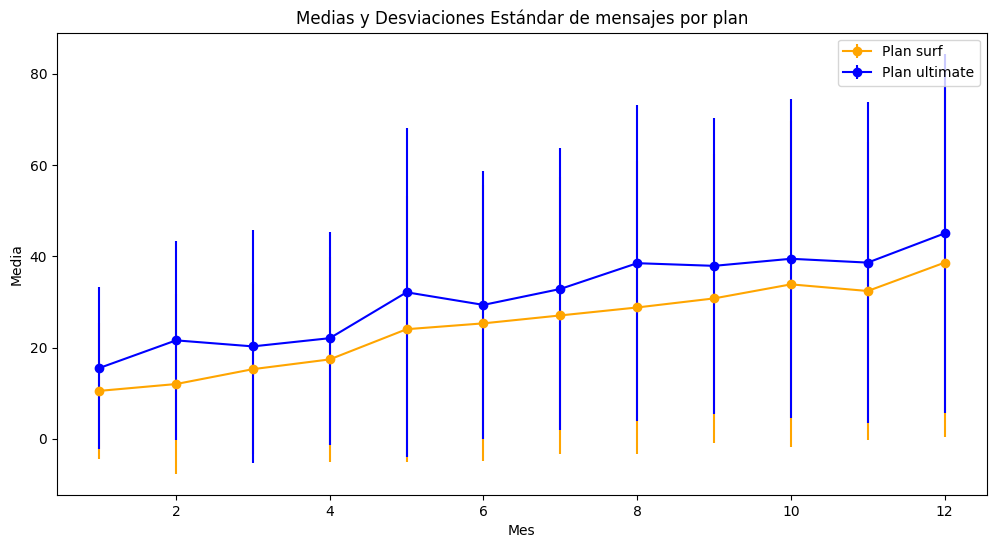

In [37]:
# Calcular la media y la varianza de los mensajes.
# Calcular la media y varianza solo para la columna "messages"
merge_mean_var_messages_messages = user_messages_month.groupby(
    ["month", "plan"])["messages"].agg(['mean', 'var', "std"]).reset_index()
display(merge_mean_var_messages_messages)

# Crear la gráfica con bandas de error
plt.figure(figsize=(12, 6))

for plan, color in zip(merge_mean_var_messages_messages['plan'].unique(), ['orange', 'blue']):
    subset = merge_mean_var_messages_messages[merge_mean_var_messages_messages['plan'] == plan]
    plt.errorbar(subset['month'], subset['mean'], yerr=subset['std'],
                 fmt='-o', label=f'Plan {plan}', color=color)

plt.title('Medias y Desviaciones Estándar de mensajes por plan')
plt.xlabel('Mes')
plt.ylabel('Media')
plt.legend()
plt.show()

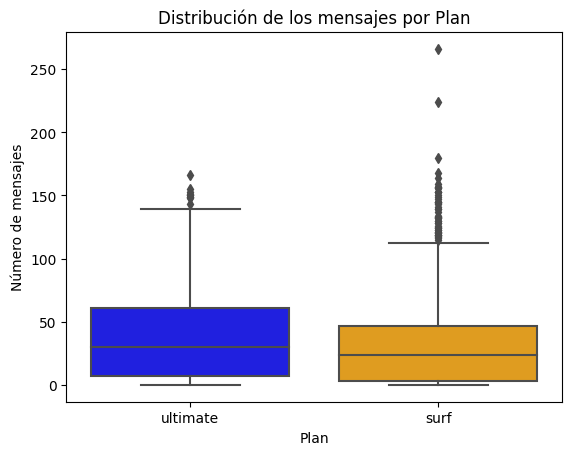

In [38]:
# Traza un diagrama de caja para visualizar la distribución de los mensajes
sns.boxplot(x="plan", y="messages", data=merge_per_month_plan[[
            "month", "plan", "messages"]],  palette=['blue', 'orange'])
plt.title('Distribución de los mensajes por Plan')
plt.xlabel('Plan')
plt.ylabel('Número de mensajes')
plt.show()

Se observan ligeras diferencias en el comportamiento de los usuarios con respecto a los mensajes, de acuerdo al plan.

En la primera gráfica vemos la comparación de mensajes a lo largo del año, de acuerdo al plan de los usuarios. Observamos un aumento en ambos planes conforme avanza el año, llegando a casi duplicar la cantidad de mensajes en el plan "surf" que en el plan "ultimate". 

En el histograma observamos que hay una mayor frecuencia de usuarios que mandan mensajes en el plan "surf", al menos tres veces a comparación del plan "ultimate". Observamos que ambos planes poseen un comportamiento similar con un sesgo a la derecha.

Luego analizamos el promedio y la varianza de los mensajes. Graficamos el promedio y la desviación estandar (sacando la raiz cuadrada de la varianza) y observamos que las desviaciones se sobrelapan entre si. Este es un indicio de que no hay diferencias significativas entre los comportamientos entre ambos planes. Se observó que la media es mayor en el plan "ultimate" a comparación del plan "surf". 

En la gráfica de caja y bigotes observamos que ambas cajas son relativamente cortas y solo uno de sus bigotes es largo, indicando una distribución donde la mayoría de los datos se concentran alrededor de los 30 mensajes. Se observan algunos valores extremos. En el plan "surf" se observá un mayor sesgo debido a estos últimos.  La caja del plan "ultimate" muestra un cuartil 3, una mediana y un valor máximo mayor a comparación del plan "surf", aunque minimamente, considerando que el plan tiene como base 1000 mensajes que pueden usar los usuarios. A comparación, la caja de los mensajes del plan "surf, ni siquiera sobrepasa los 50 que se tienen de manera estándar en el plan.

### Internet

,ultimate,surf
month,,
1,29,10
2,121,110
3,221,312
4,343,611
5,489,1087
6,725,1502
7,973,2042
8,1267,2735
9,1463,3238


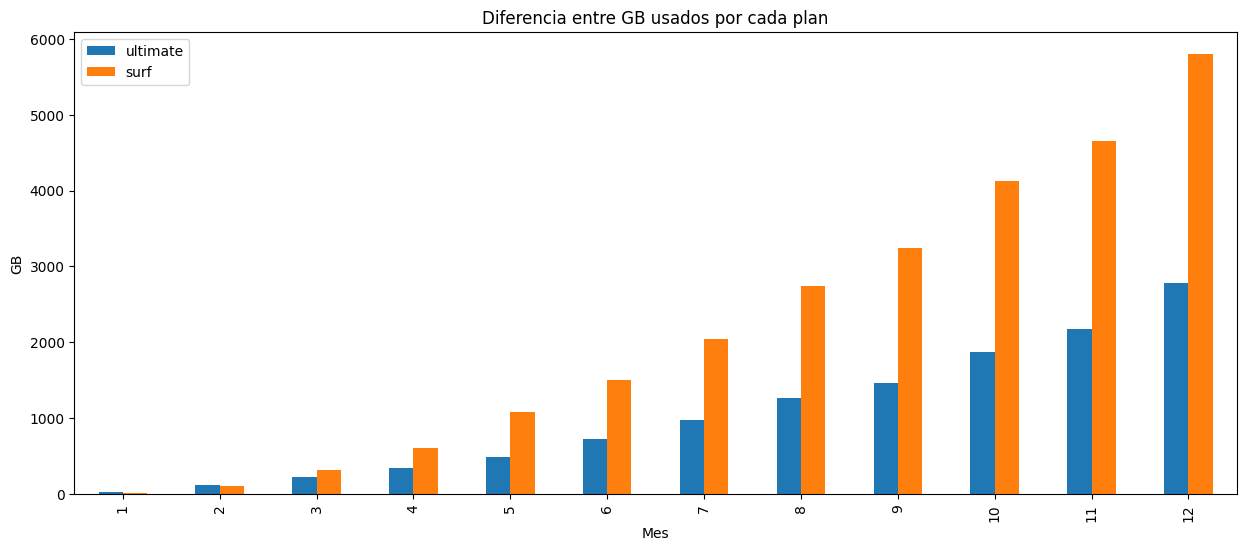

In [39]:
# Comparar el número de mensajes que tienden a enviar cada mes los usuarios de cada plan

# Primero usando el dataframe de merge_per_month_plan separamos los datos en dos dataframes de acuerdo al plan,
# con las columnas que nos interesan.
internet_ultimate = merge_per_month_plan[(
    merge_per_month_plan["plan"] == "ultimate")][["month", "gb"]]
internet_surf = merge_per_month_plan[(
    merge_per_month_plan["plan"] == "surf")][["month", "gb"]]

# Tercero, agrupamos los datos para obtener los  de mensajes por mes.
internet_ultimate = internet_ultimate.groupby("month")["gb"].sum()
internet_surf = internet_surf.groupby("month")["gb"].sum()

# Cuarto, concatenamos.
internet_concat = pd.concat([internet_ultimate, internet_surf], axis=1)
internet_concat.columns = ["ultimate", "surf"]
display(internet_concat)

# Quinto, mostramos la gráfica.
internet_concat.plot(kind='bar',
                     title='Diferencia entre GB usados por cada plan',
                     xlabel='Mes',
                     ylabel='GB',
                     figsize=[15, 6])
plt.legend(['ultimate', 'surf'])
plt.show()

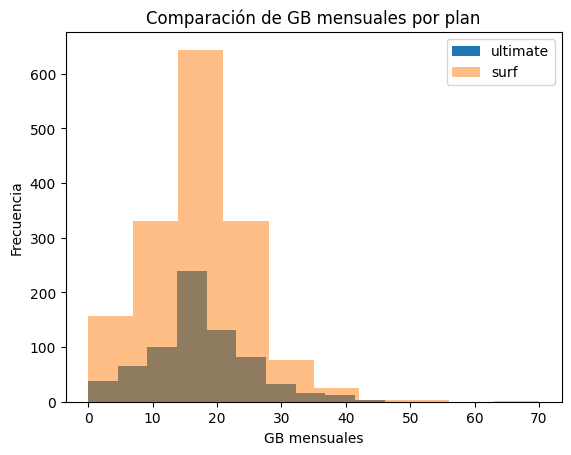

In [40]:
# Comparar la cantidad de tráfico de Internet consumido mensual por plan
# Primero usando el dataframe de merge_per_month_plan separamos los datos en un nuevo dataframe de acuerdo al plan,
# con las columnas que nos interesan.
user_mmb_month = merge_per_month_plan[["month", "gb", "plan"]]

# Segundo, mostrar el gráfico del plan ultimate y surf
user_mmb_month[user_mmb_month["plan"] == "ultimate"]["gb"].plot(kind='hist', )
user_mmb_month[user_mmb_month["plan"] ==
               "surf"]["gb"].plot(kind='hist', alpha=0.5)

# Tercero, mostrar el gráfico.
plt.legend(['ultimate', 'surf'])
plt.title('Comparación de GB mensuales por plan')
plt.xlabel('GB mensuales')
plt.ylabel('Frecuencia')
plt.show()

,month,plan,mean,var,std
0,1,surf,5.000000,18.000000,4.242641
1,1,ultimate,7.250000,14.916667,3.862210
2,2,surf,12.222222,41.444444,6.437736
3,2,ultimate,17.285714,37.904762,6.156684
4,3,surf,13.565217,63.984190,7.999012
5,3,ultimate,18.416667,138.628788,11.774073
6,4,surf,12.220000,56.215918,7.497728
7,4,ultimate,16.333333,85.833333,9.264628
8,5,surf,14.116883,58.183527,7.627813
9,5,ultimate,16.862069,54.194581,7.361697


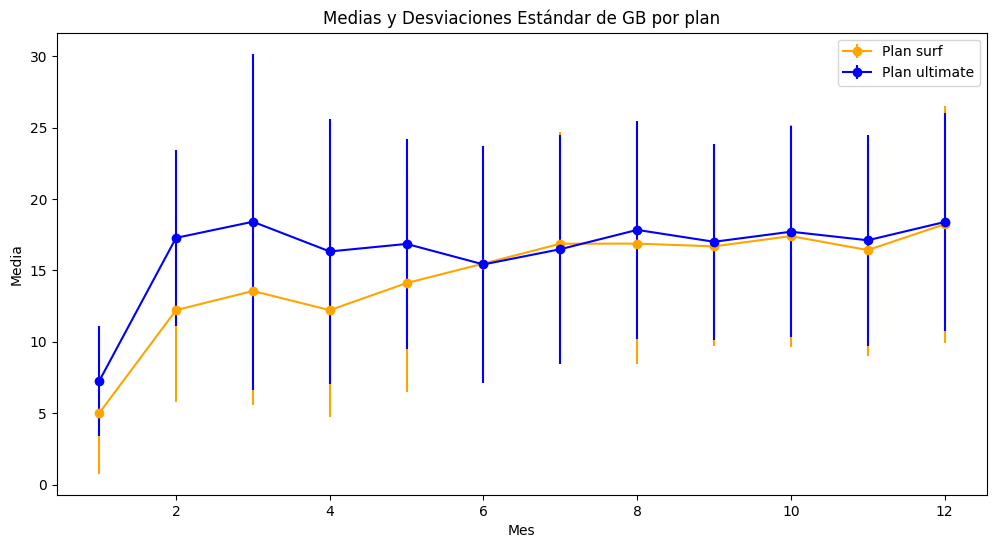

In [41]:
# Calcular la media y la varianza de los GB.
# Calcular la media y varianza solo para la columna "gb"
merge_mean_var_mb = user_mmb_month.groupby(["month", "plan"])["gb"].agg([
    'mean', 'var', "std"]).reset_index()
display(merge_mean_var_mb)

# Crear la gráfica con bandas de error
plt.figure(figsize=(12, 6))

for plan, color in zip(merge_mean_var_mb['plan'].unique(), ['orange', 'blue']):
    subset = merge_mean_var_mb[merge_mean_var_mb['plan'] == plan]
    plt.errorbar(subset['month'], subset['mean'], yerr=subset['std'],
                 fmt='-o', label=f'Plan {plan}', color=color)

plt.title('Medias y Desviaciones Estándar de GB por plan')
plt.xlabel('Mes')
plt.ylabel('Media')
plt.legend()
plt.show()

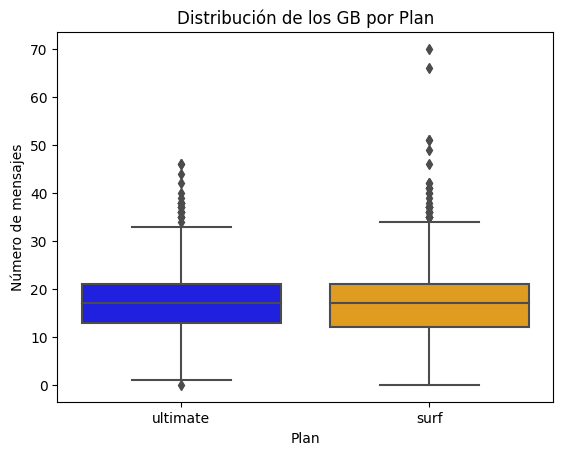

In [42]:
# Traza un diagrama de caja para visualizar la distribución de los GB
sns.boxplot(x="plan", y="gb", data=merge_per_month_plan[[
            "month", "plan", "gb"]],  palette=['blue', 'orange'])
plt.title('Distribución de los GB por Plan')
plt.xlabel('Plan')
plt.ylabel('Número de mensajes')
plt.show()

Se observan ligeras diferencias en el comportamiento de los usuarios con respecto a los GB, de acuerdo al plan. 

En la primera gráfica vemos la comparación de los GB usados a lo largo del año, de acuerdo al plan de los usuarios. Observamos un aumento en ambos planes conforme avanza el año, llegando a casi duplicar la cantidad de GB en el plan "surf" que en el plan "ultimate". 

En el histograma observamos que hay una mayor cantidad de GB usados mensuales en el plan "surf, aproximadamente tres veces a comparación del plan "ultimate". Observamos que ambos planes poseen unn comportamiento similar con un ligero sesgo a la derecha. 

Luego analizamos el promedio y la varianza los GB usados por plan. Graficamos el promedio y la desviación estandar (sacando la raiz cuadrada de la varianza) y observamos que las desviaciones se sobrelapan entre si. Este es un indicio de que no hay diferencias significativas entre los comportamientos entre ambos planes. Se observó que la media es mayor en el plan "ultimate" a comparación del plan "surf", hasta la mitad del año. Luego observamos que ambos poseen un promedio y desviación estándar similar. 

En la gráfica de caja y bigotes observamos que ambas cajas son relativamente cortas y con ambos  bigotes es largos, indicando una distribución donde la mayoría de los datos se concentran alrededor de los 15-20 gigabytes. Se observan algunos valores extremos en ambos planes. En el plan "surf" se observá un mayor sesgo debido a estos últimos, con una mayor cantidad de valores extremos. 

## Ingreso

,ultimate,surf
month,,
1,280.0,40.00
2,490.0,309.57
3,896.0,1056.65
4,1533.0,2035.53
5,2051.0,3667.37
6,3367.0,4779.80
7,4242.0,7583.56
8,5173.0,10356.85
9,6195.0,11304.67


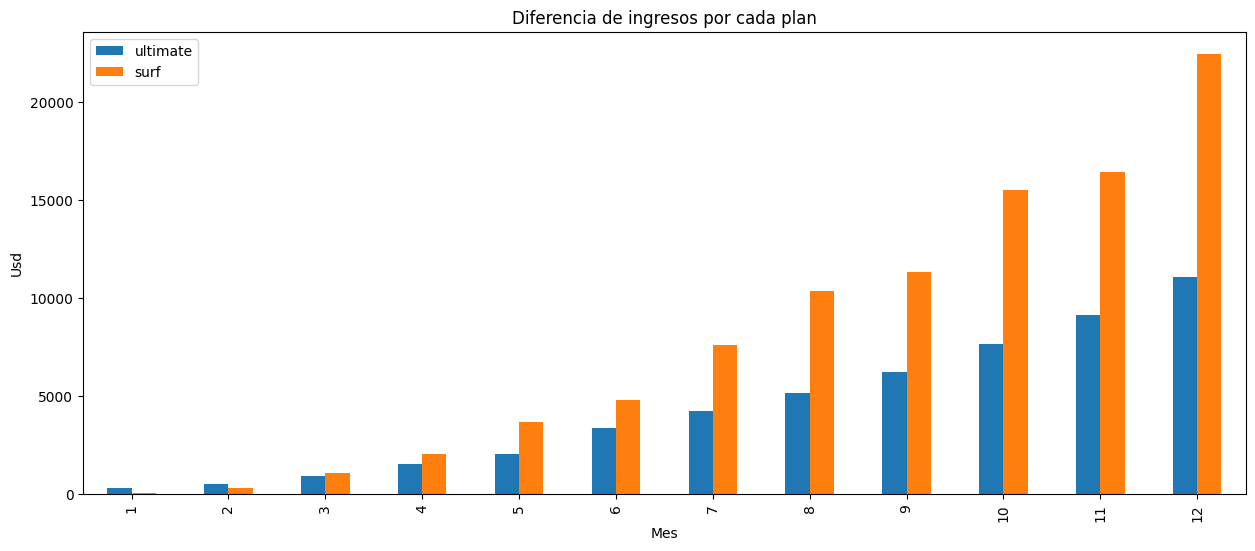

In [43]:
# Comparar los ingresos de los usuarios de cada plan

# Primero usando el dataframe de merge_per_month_plan separamos los datos en dos dataframes de acuerdo al plan,
# con las columnas que nos interesan.
income_ultimate = merge_per_month_plan[(
    merge_per_month_plan["plan"] == "ultimate")][["month", "user_income"]]
income_surf = merge_per_month_plan[(merge_per_month_plan["plan"] == "surf")][[
    "month", "user_income"]]

# Tercero, agrupamos los datos para obtener los ingresos por mes.
income_ultimate = income_ultimate.groupby("month")["user_income"].sum()
income_surf = income_surf.groupby("month")["user_income"].sum()

# Cuarto, concatenamos.
income_concat = pd.concat([income_ultimate, income_surf], axis=1)
income_concat.columns = ["ultimate", "surf"]
display(income_concat)

# Quinto, mostramos la gráfica.
income_concat.plot(kind='bar',
                   title='Diferencia de ingresos por cada plan',
                   xlabel='Mes',
                   ylabel='Usd',
                   figsize=[15, 6])
plt.legend(['ultimate', 'surf'])
plt.show()

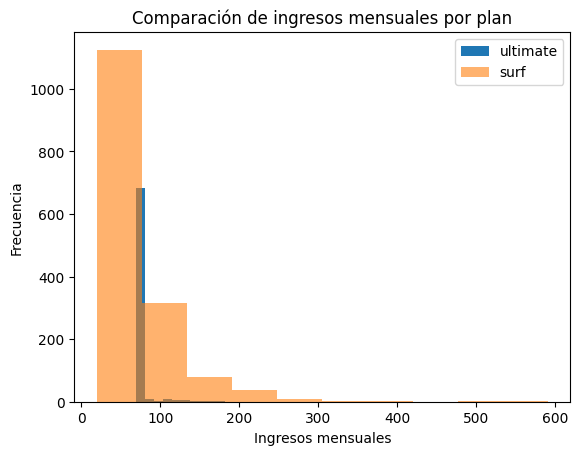

In [44]:
# Comparar la cantidad ingresos mensuales por plan

# Primero usando el dataframe de merge_per_month_plan separamos los datos en un nuevo dataframe de acuerdo al plan,
# con las columnas que nos interesan.
user_usd_month = merge_per_month_plan[["month", "user_income", "plan"]]

# Segundo, mostrar el gráfico del plan surf y ultimate
user_usd_month[user_usd_month["plan"] ==
               "ultimate"]["user_income"].plot(kind='hist')
user_usd_month[user_usd_month["plan"] ==
               "surf"]["user_income"].plot(kind='hist', alpha=0.6)

# Tercero,  mostrar el gráfico
plt.legend(['ultimate', 'surf'])
plt.title('Comparación de ingresos mensuales por plan')
plt.xlabel('Ingresos mensuales')
plt.ylabel('Frecuencia')
plt.show()

,month,plan,mean,var,std
0,1,surf,20.000000,0.000000,0.000000
1,1,ultimate,70.000000,0.000000,0.000000
2,2,surf,34.396667,428.276100,20.694833
3,2,ultimate,70.000000,0.000000,0.000000
4,3,surf,45.941304,1512.023512,38.884747
5,3,ultimate,74.666667,145.515152,12.062966
6,4,surf,40.710600,1198.958402,34.625979
7,4,ultimate,73.000000,120.400000,10.972693
8,5,surf,47.628182,1967.540055,44.356962
9,5,ultimate,70.724138,15.206897,3.899602


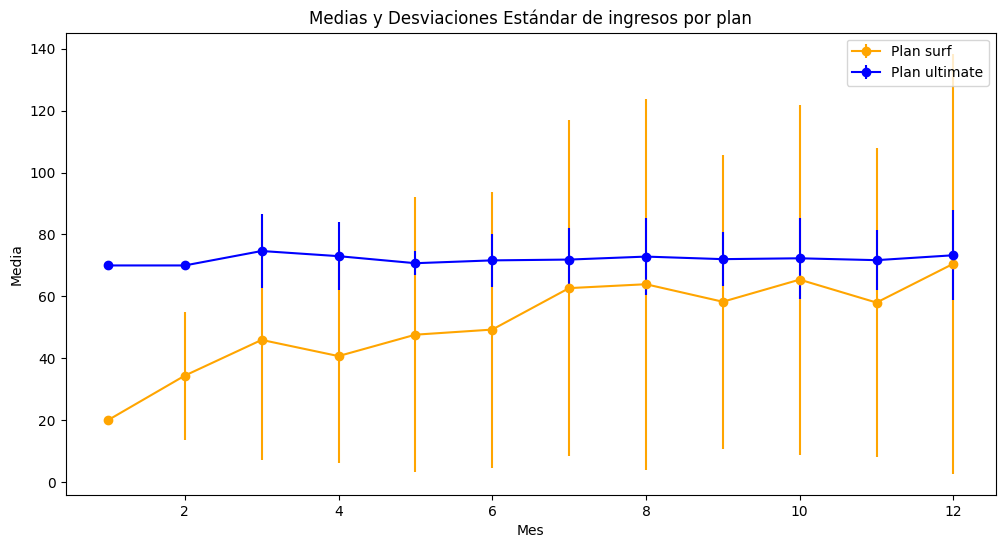

In [45]:
# Calcular la media y la varianza de los ingresos.
# Calcular la media y varianza solo para la columna "messages"
mean_var_usd = user_usd_month.groupby(["month", "plan"])["user_income"].agg([
    'mean', 'var', "std"]).reset_index()
display(mean_var_usd)

# Crear la gráfica con bandas de error
plt.figure(figsize=(12, 6))

for plan, color in zip(mean_var_usd['plan'].unique(), ['orange', 'blue']):
    subset = mean_var_usd[mean_var_usd['plan'] == plan]
    plt.errorbar(subset['month'], subset['mean'], yerr=subset['std'],
                 fmt='-o', label=f'Plan {plan}', color=color)

plt.title('Medias y Desviaciones Estándar de ingresos por plan')
plt.xlabel('Mes')
plt.ylabel('Media')
plt.legend()
plt.show()

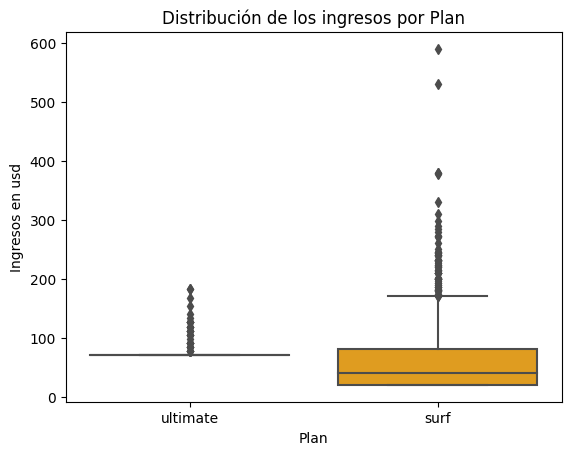

In [46]:
# Traza un diagrama de caja para visualizar la distribución de los ingresos por plan
sns.boxplot(x="plan", y="user_income", data=merge_per_month_plan[[
            "month", "plan", "user_income"]],  palette=['blue', 'orange'])
plt.title('Distribución de los ingresos por Plan')
plt.xlabel('Plan')
plt.ylabel('Ingresos en usd')
plt.show()

Se observan ciertas diferencias en los ingresos de acuerdo al plan que usan los usuarios. 

En la primera gráfica vemos la comparación de ingresos de acuerdo al plan. Conforme avanza el año se observá un aumento en los ingresos por parte de ambos planes. Al inicio el plan "ultimate" era más rentable hasta el mes de Marzo. Luego de esto, los ingresos del plan "surf" fueron aumentando hasta ser más del doble en Diciembre. 

En el histograma observamos que hay una mayor porporción de ingresos por parte del plan "surf". Los ingresos del plan "ultimate" principalmente se encuentran en los 70 dolares base del pago mensual. 

Luego analizamos el promedio y la varianza los ingresos por plan. Graficamos el promedio y la desviación estandar (sacando la raiz cuadrada de la varianza) y observamos que las desviaciones se sobrelapan entre sí a partir de Marzo. Se analizará con más detalle usando pruebas estadísticas, para verificar si existen diferencias significativas entre los planes. Anteriormente, el plan "ultimate" era más rentable. Sin embargo, los mayores ingresos parecen venir del plan "surf".

En la gráfica de caja y bigotes observamos que hay una marcada diferencia entre los ingresos de ambos planes. La caja de los ingresos del plan "utimate" es demasiado corta. No se alcanza a apreciar una diferencia entre cuartiles, valor máximo, valor mínimo y la mediana. Los cuales están alrededor de los 70 dólares que vale el plan "ultimate". 
En la caja del plan "surf" observamos una diferencia entre cuartiles y la mediana, que parece encontrarse cercano a los 20 dólares de precio base. Aquí encontramos la mayor cantidad de valores extremos. 

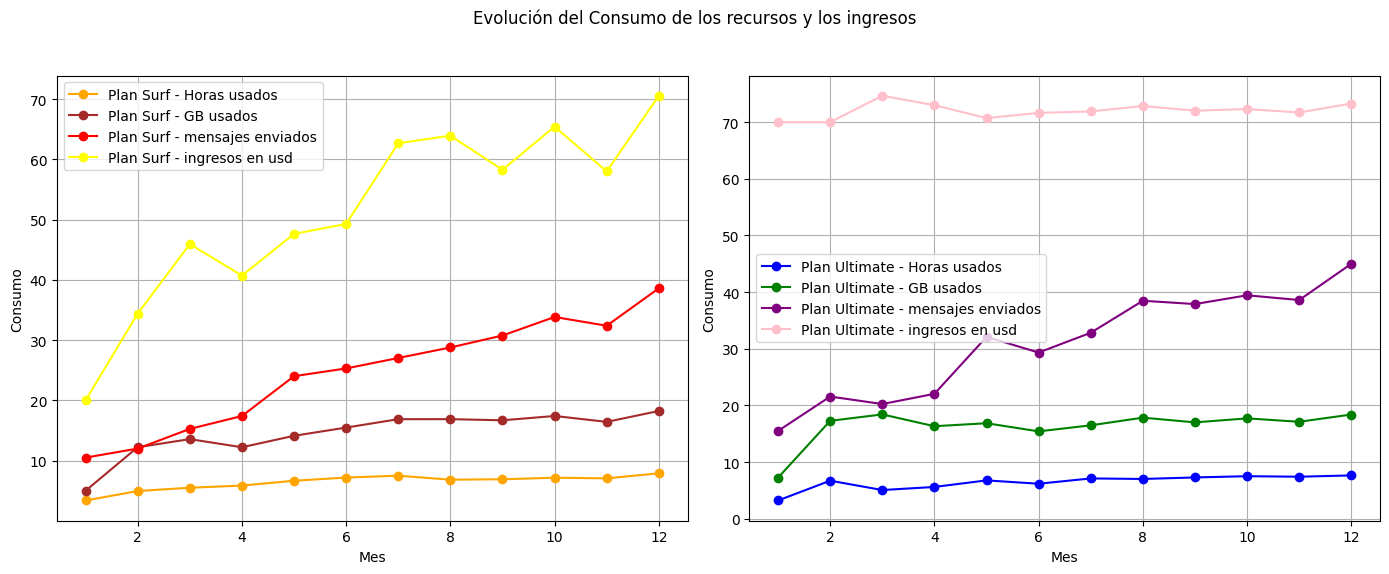

In [47]:
import matplotlib.pyplot as plt


def plot_plan_data(ax, plan_data, label, color):
    ax.plot(plan_data["month"], plan_data["mean"],
            label=label, marker='o', color=color)


# Datos
# Se transformaron los minutos a horas para mejorar su observación junto con los otros recursos
ultimate_min = merge_mean_var_stats_min[merge_mean_var_stats_min["plan"] == "ultimate"].copy(
)
ultimate_min["mean"] = ultimate_min["mean"] / 60
surf_min = merge_mean_var_stats_min[merge_mean_var_stats_min["plan"] == "surf"].copy(
)
surf_min["mean"] = surf_min["mean"] / 60

# Se usan los GB para mejorar su observación junto con los otros recursos
ultimate_mb = merge_mean_var_mb[merge_mean_var_mb["plan"] == "ultimate"].copy()
# ultimate_mb["mean"] = ultimate_mb["mean"] / 1024
surf_mb = merge_mean_var_mb[merge_mean_var_mb["plan"] == "surf"].copy()
# surf_mb["mean"] = surf_mb["mean"] / 1024

ultimate_messages = merge_mean_var_messages_messages[merge_mean_var_messages_messages["plan"] == "ultimate"].copy(
)
surf_messages = merge_mean_var_messages_messages[merge_mean_var_messages_messages["plan"] == "surf"].copy(
)

ultimate_income = mean_var_usd[mean_var_usd["plan"] == "ultimate"].copy()
surf_income = mean_var_usd[mean_var_usd["plan"] == "surf"].copy()

# Configurar dos subgráficas
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Evolución del Consumo de los recursos y los ingresos")

# Graficar datos para el plan Surf
plot_plan_data(axes[0], surf_min, "Plan Surf - Horas usados", "orange")
plot_plan_data(axes[0], surf_mb, "Plan Surf - GB usados", "brown")
plot_plan_data(axes[0], surf_messages, "Plan Surf - mensajes enviados", "red")
plot_plan_data(axes[0], surf_income, "Plan Surf - ingresos en usd", "yellow")

axes[0].set_xlabel("Mes")
axes[0].set_ylabel("Consumo")
axes[0].legend()
axes[0].grid(True)

# Graficar datos para el plan Ultimate
plot_plan_data(axes[1], ultimate_min, "Plan Ultimate - Horas usados", "blue")
plot_plan_data(axes[1], ultimate_mb, "Plan Ultimate - GB usados", "green")
plot_plan_data(axes[1], ultimate_messages,
               "Plan Ultimate - mensajes enviados", "purple")
plot_plan_data(axes[1], ultimate_income,
               "Plan Ultimate - ingresos en usd", "pink")

axes[1].set_xlabel("Mes")
axes[1].set_ylabel("Consumo")
axes[1].legend()
axes[1].grid(True)

# Ajustar diseño de las subgráficas
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Mostrar las gráficas
plt.show()

Se hizo una comparación de los promedios del consumo de mensajes, horas de llamadas, Gigabytes e ingresos de acuerdo al plan usado por los usuarios. Para esto fue necesario convertir los minutos de duración de llamadas a horas. De esta forma podemos observar que la duración de llamadas y los GB's usados se encuentran relativamente uniformes. No parece haber diferencias significativas en la duración de las llamadas en ambos planes. 

En el caso de los GB usados en el plan Surf a lo largo del año vemos una tendencia a un mayor uso de los mismos, hasta casi igualar el consumo por parte de los usuarios del plan Ultimate. 

En el caso de los mensajes, en ambos planes vemos una tendencia al aumento del uso de los mismos, con la única diferencia en cuanto a las cantidades usadas. Esto podría estar ligado a el límite de mensajes incluidos en el plan Surf, quienes en promedio no sobrepasan los mensajes mensuales disponibles.

Los ingresos por parte del plan Ultimate se mantienen uniformes a lo largo del año, a diferencia de los ingresos del plan Surf, que han crecido más de tres veces a lo largo del año. En promedio aún no alcanzan los ingresos mensuales pertenecientes del plan Ultimate aunque la tendencia parece indicar que los ingresos podrían seguir creciendo en el plan Surf. 

## Prueba las hipótesis estadísticas

Se va a analizar si los promedios de los ingresos son iguales entre ambos planes. 

Primero debemos verificar la similitud estadística de las varianzas de los ingresos de ambos planes, para poder analizar si las medias de los ingresos de ambos planes son iguales. Si hay una diferencia significativa en las varianzas de ambos grupos, en la prueba de t de student tendremos que agregar "equal_var=False" para que se considere una Prueba t de Welch.

Para esto tenemos dos hipótesis:

-Hipótesis nula (H0): No hay diferencia significativa entre las varianzas de los ingresos de ambos planes. 

-Hipótesis alternativa (H1): Hay una diferencia significativa entre las varianzas de los ingresos de ambos planes.

In [48]:
alpha = 0.05
# Guardamos el promedio que será utilizado para la prueba de t de student y la prueba de Levine.
income_ultimate_st = mean_var_usd[(
    mean_var_usd["plan"] == "ultimate")][["mean"]]
income_surf_st = mean_var_usd[(mean_var_usd["plan"] == "surf")][["mean"]]

# hacemos listas de ambos dataframes para la prueba de Levine.
income_ultimate_st_lv = income_ultimate_st["mean"].tolist()
income_surf_st_lv = income_surf_st["mean"].tolist()

# hacemos la prueba de Levine.
lv_result = st.levene(income_ultimate_st_lv, income_surf_st_lv)

# extraemos el valor p
print('valor p: ', lv_result.pvalue)

# comparamos el valor p con el umbral
if lv_result.pvalue < alpha:
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula")

valor p:  0.00023614333642490865
Rechazamos la hipótesis nula


Rechazamos la hipótesis de que las varianzas de ambos grupos son iguales. De tal forma que podemos seguir con la prueba de t de Welch, donde se considera que las varianzas no son iguales.

Para esto tenemos dos hipótesis:

-Hipótesis nula (H0): No hay diferencia significativa entre las medias de los ingresos de ambos planes. 

-Hipótesis alternativa (H1): Hay una diferencia significativa entre las medias de los ingresos de ambos planes.

Realizamos la prueba estadística luego de elegir alpha (asegurandonos de poner "equal_var=False", para que se relice la prueba de t de Welch, donde se considera que las varianzas no son iguales en ambos grupos, debido al resultado de la prueba de Levine en el inciso anterior):

In [49]:
alpha = 0.05
results = st.ttest_ind(income_ultimate_st, income_surf_st, equal_var=False)

# extraemos el valor p
print('valor p: ', results.pvalue)

# comparamos el valor p con el umbral
if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula")

valor p:  [0.00049702]
Rechazamos la hipótesis nula


Rechazamos la hiótesis de que las medias de ambos grupos son iguales. Este análisis complementa lo observado en las gráficas anteriores de boxplot (caja y bigotes) y en la gráfica de medias y desviación estandar de los ingresos por plan. 

Ahora se va a analizar si el ingreso promedio de los usuarios del área NY-NJ es distinta del de otras regiones.

Primero debemos verificar la similitud estadística de las varianzas de los ingresos de ambos planes, para poder analizar si las medias de los ingresos de ambos planes son iguales. Si hay una diferencia significativa en las varianzas de ambos grupos, en la prueba de t de student tendremos que agregar "equal_var=False" para que se considere una Prueba t de Welch.

Para esto tenemos dos hipótesis:

-Hipótesis nula (H0): No hay diferencia significativa entre las varianzas de los ingresos de ambos planes. 

-Hipótesis alternativa (H1): Hay una diferencia significativa entre las varianzas de los ingresos de ambos planes.

In [50]:
# Primero añadimos las ciudades al dataframe donde están los ingresos
merge_df = merge_per_month_plan.merge(
    users[["user_id", "city"]], on=["user_id"])

# Segundo, filtramos y hacemos dos dataframes de acuerdo a si están en el área NY-NJ o no
merge_df_ny_nj = merge_df[(
    merge_df["city"] == "new york-newark-jersey city, ny-nj-pa msa")]
merge_df__not_ny_nj = merge_df[(
    merge_df["city"] != "new york-newark-jersey city, ny-nj-pa msa")]

# Tercero, agrupamos por mes y plan y obtenemos el promedio los ingresos
income_st_NY_NJ = merge_df_ny_nj.groupby(["month", "plan"])[
    "user_income"].mean().reset_index()
income_st_not_NY_NJ = merge_df__not_ny_nj.groupby(
    ["month", "plan"])["user_income"].mean().reset_index()

# Guardamos el promedio que será utilizado para la prueba de t de student y la prueba de Levine.
income_st_NY_NJ_mean = income_st_NY_NJ[["user_income"]]
income_st_not_NY_NJ_mean = income_st_not_NY_NJ[["user_income"]]

# hacemos listas de ambos dataframes para la prueba de Levine.
income_st_NY_NJ_mean_lv = income_st_NY_NJ_mean["user_income"].tolist()
income_st_not_NY_NJ_mean_lv = income_st_not_NY_NJ_mean["user_income"].tolist()

# hacemos la prueba de Levine.
lv_result = st.levene(income_st_NY_NJ_mean_lv, income_st_not_NY_NJ_mean_lv)

print('valor p: ', lv_result.pvalue)  # extraemos el valor p

if lv_result.pvalue < alpha:  # comparamos el valor p con el umbral
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula")

valor p:  0.6243491009751267
No podemos rechazar la hipótesis nula


Como no podemos rechazar la hipótesis de que las varianzas sean iguales, se hará una prueba T de student (con "equal_var=True").
Para esto tenemos dos hipótesis:

-Hipótesis nula (H0): No hay diferencia significativa entre las medias de los ingresos de ambos planes. 

-Hipótesis alternativa (H1): Hay una diferencia significativa entre las medias de los ingresos de ambos planes.

In [51]:
# Realizamos la prueba estadística luego de elegir alpha:
alpha = 0.05

results = st.ttest_ind(income_st_NY_NJ_mean,
                       income_st_not_NY_NJ_mean, equal_var=True)

print('valor p: ', results.pvalue)  # extraer el valor p

if results.pvalue < alpha:  # comparar el valor p con el umbral
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula")

valor p:  [0.97740225]
No podemos rechazar la hipótesis nula


No podemos rechazar la hipótesis de que ambas poblaciones posean promedios de ingresos similares, con lo cual inferimos que al menos en el área NY-NJ no presenta diferencia en el uso de los planes y/o recursos (mensajes, minutos, GB) con respecto al resto de la población.

## Conclusión general

En este trabajo se buscó analizar las diferencias entre los planes "surf" y "ultimate" en los parámetros de mensajes, GB usados, llamadas (junto con el promedio de duración de las mismas) y los ingresos en dólares. 

No se observaron diferencias en el uso o la duración de las llamadas en los diferentes planes. Si se observó una mayor proporción de llamadas en el plan "surf", aunque esto puede estar explicado por que la mayoría de los usuarios presentan este plan (Alrededor del doble a comparación del plan "ultimate"). 

Se observaron ligeras diferencias en el comportamiento de los usuarios con respecto a los mensajes y GB, de acuerdo al plan. Se observó una  proporción aproximadamente 3 veces mayor de usuarios mandando mensajes en el plan "surf" y dos veces mayor en el consumo de GB a comparación del plan "ultimate. Se observó un mayor sesgo por valores extremos tanto de mensajes como de GB del plan "surf". En el caso de los MB usados en el plan Surf a lo largo del año vemos una tendencia a un mayor uso de los mismos, hasta casi igualar el consumo por parte de los usuarios del plan Ultimate. En el caso de los mensajes, en ambos planes vemos una tendencia al aumento del uso de los mismos a lo largo del año.

Se observan ciertas diferencias en los ingresos de acuerdo al plan que usan los usuarios. Los mayores ingresos vienen del plan "surf", aunque parecen estar relacionados a la cantidad de gente que los utiliza y a ciertos usuarios que generan valores extremos (por el cual se les cobra extra por los mensajes, minutos y gigabytes). Los ingresos por parte del plan Ultimate se mantienen uniformes a lo largo del año, a diferencia de los ingresos del plan Surf, que han crecido más de tres veces a lo largo del año. La tendencia parece indicar que los ingresos podrían seguir creciendo en el plan Surf. 

Al hacer la prueba estadísatica de la t de student para corroborar si los promedios de los ingresos son iguales entre si, encontramos que podemos rechazar esta hipotesis. Los promedios de ingresos entre planes poseen una diferencia significativa, estadisticamente hablando.

Queriendo observar si dependiendo de un área especifica podría haber una diferencia entre el uso de un plan u otro y de esta forma de los ingresos, se hizó a prueba de t de student para corroborar si los promedios de los ingresos de la población del área NY-NJ, son similares con respecto al del resto de la población. Encontramos que no podemos rechazar la hipótesis de que ambas poblaciones poseen promedios de ingresos similares. 